# 필요한 라이브러리

In [1]:
import cv2
import mediapipe as mp
from colorthief import ColorThief
import extcolors
import colorsys
import matplotlib.pyplot as plt
import numpy as np
from colormath.color_objects import LabColor, sRGBColor, HSVColor
from colormath.color_conversions import convert_color

# Parameter 설정

In [2]:
image_name = 'face01'
image_path = f'./Data/image/{image_name}.jpg'
image_crop_path = f'./Data/image/{image_name}_part.jpeg'
image_bcrop_path = f'./Data/image/{image_name}_back.jpeg'
palette_num = 100

# 사진의 얼굴 영역 가져오기

In [3]:
def plt_imshow(title='image', img=None, figsize=(8 ,5), isSave=False, imgName=None):
    plt.figure(figsize=figsize)
 
    if type(img) == list:
        if type(title) == list:
            titles = title
        else:
            titles = []
 
            for i in range(len(img)):
                titles.append(title)
 
        for i in range(len(img)):
            if len(img[i].shape) <= 2:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_GRAY2RGB)
            else:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)
 
            plt.subplot(1, len(img), i + 1), plt.imshow(rgbImg)
            plt.title(titles[i])
            plt.xticks([]), plt.yticks([])
 
        plt.show()
    else:
        if len(img.shape) < 3:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
 
        plt.imshow(rgbImg)
        plt.title(title)
        plt.xticks([]), plt.yticks([])
        plt.show()
    
    if isSave == True:
        if imgName is None:
            print("Set New Image Name")
        else:
            plt.imsave(imgName,rgbImg)

In [4]:
image = cv2.imread(image_path)
print(f'Image Size: {image.shape}')

mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils

Image Size: (1440, 1440, 3)


Found 1 faces.


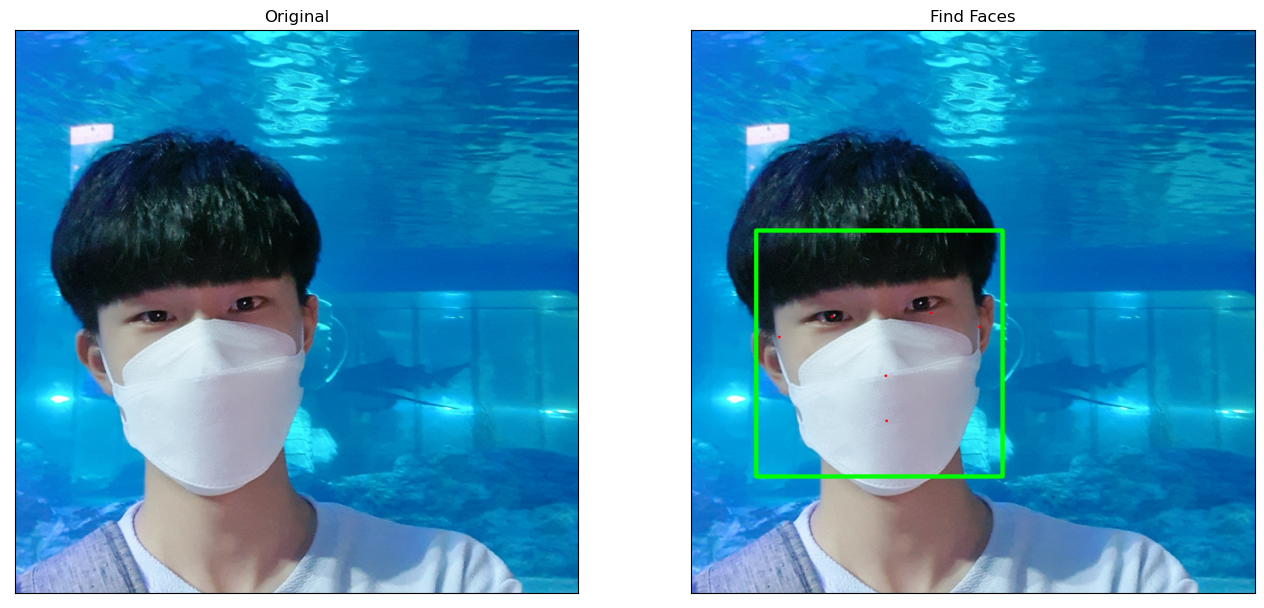

In [5]:
with mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5) as face_detection:
    results = face_detection.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    result_obj = results.detections[0].location_data
    
    # Draw face detections of each face.
    if not results.detections:
        print("Face not found in image")
    else:
        print('Found {} faces.'.format(len(results.detections)))
        
        annotated_image = image.copy()
        # print(annotated_image.shape)
        for detection in results.detections:
            # print(mp_face_detection.get_key_point(detection, mp_face_detection.FaceKeyPoint.NOSE_TIP))
            mp_drawing.draw_detection(annotated_image, detection, bbox_drawing_spec=mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=10))
            
        plt_imshow(["Original", "Find Faces"], [image, annotated_image], figsize=(16,10), isSave=False)

## 얼굴 영역 인식 및 추출

In [6]:
image_y_size = image.shape[0]
image_x_size = image.shape[1]

target_xmin = int(result_obj.relative_bounding_box.xmin*image_x_size) if result_obj.relative_bounding_box.xmin >= 0 else int(result_obj.relative_bounding_box.xmin*image_x_size * -1)
target_ymin = int(result_obj.relative_bounding_box.ymin*image_y_size) if result_obj.relative_bounding_box.ymin >= 0 else int(result_obj.relative_bounding_box.ymin*image_y_size * -1)
target_width = int(result_obj.relative_bounding_box.width*image_x_size)+1 if result_obj.relative_bounding_box.width >= 0 else int(result_obj.relative_bounding_box.width*image_x_size * -1 + 1)
target_height = int(result_obj.relative_bounding_box.height*image_y_size)+1 if result_obj.relative_bounding_box.height >= 0 else int(result_obj.relative_bounding_box.height*image_y_size * -1 + 1)

print(f'Bounding Box Xmin: {target_xmin}')
print(f'Bounding Box Width: {target_width}')
print(f'Bounding Box Ymin: {target_ymin}')
print(f'Bounding Box Height: {target_height}')

Bounding Box Xmin: 166
Bounding Box Width: 629
Bounding Box Ymin: 514
Bounding Box Height: 629


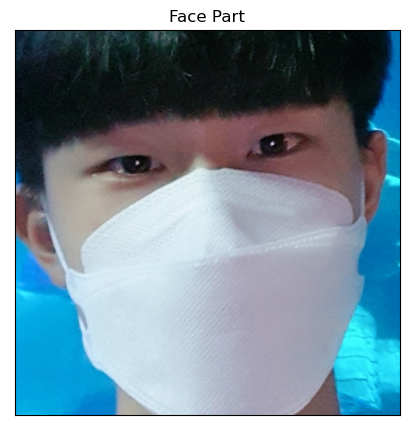

In [7]:
tmp_image = image.copy()
tmp_image = tmp_image[target_ymin:target_ymin+target_height,target_xmin:target_xmin+target_height]

plt_imshow('Face Part',tmp_image,isSave=True,imgName=image_crop_path)

## 배경 제거

In [8]:
!backgroundremover -i "./Data/image/face01_part.jpeg" -o "./Data/image/face01_back.jpeg"
print("Done.")

./Data/image/face01_back.jpegDone.



# 얼굴 영역을 망으로 시각화

In [9]:
image = cv2.imread(image_crop_path)

mp_drawing_styles = mp.solutions.drawing_styles
mp_face_mesh = mp.solutions.face_mesh

drawing_spec = mp_drawing.DrawingSpec(thickness=10, circle_radius=1)

In [10]:
static_image_mode = True
max_num_faces = 10
refine_landmarks = True
min_detection_confidence = 0.5

Found 1 faces.


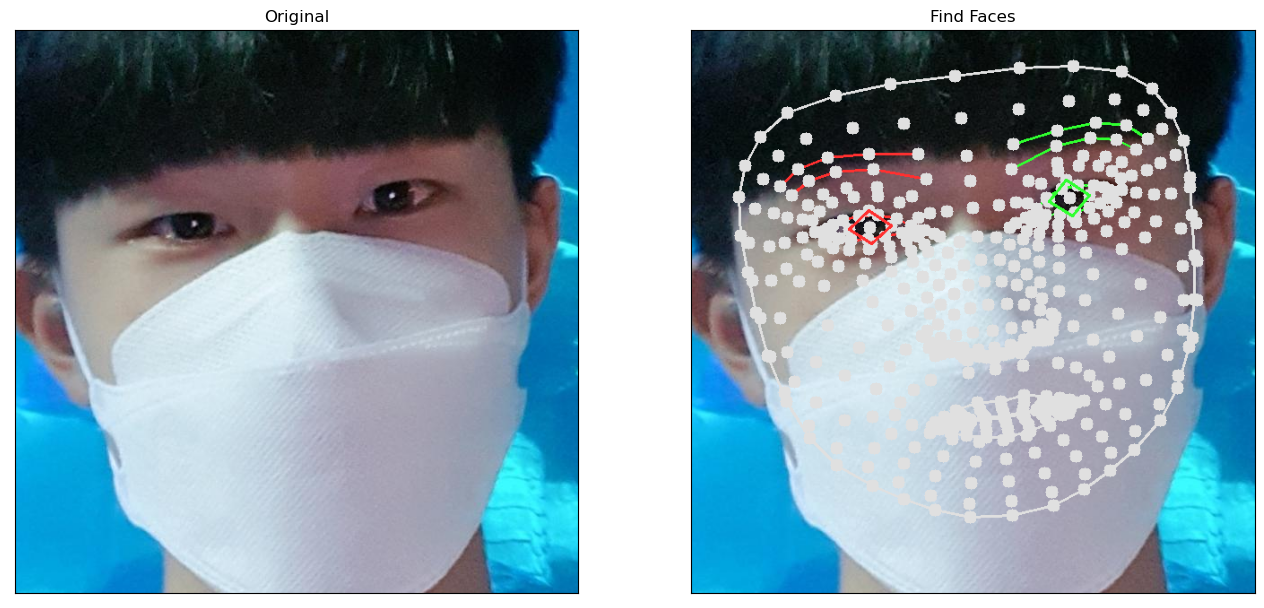

In [11]:
with mp_face_mesh.FaceMesh(static_image_mode=static_image_mode, 
                           max_num_faces=max_num_faces, 
                           refine_landmarks=refine_landmarks, 
                           min_detection_confidence=min_detection_confidence) as face_mesh:
    results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    if not results.multi_face_landmarks:
        print("Face not found in image")
    else:
        print('Found {} faces.'.format(len(results.multi_face_landmarks)))
        
        annotated_image = image.copy()
        
        for idx,face_landmarks in enumerate(results.multi_face_landmarks):
            # print(f'Num: {idx}, face_landmarks:{face_landmarks}')
            # 얼굴 부분 세공
            # mp_drawing.draw_landmarks(image=annotated_image, 
            #                           landmark_list=face_landmarks, 
            #                           connections=mp_face_mesh.FACEMESH_TESSELATION,
            #                           landmark_drawing_spec=drawing_spec, 
            #                           connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_tesselation_style())
            # 얼굴 윤곽
            mp_drawing.draw_landmarks(image=annotated_image,
                                      landmark_list=face_landmarks,
                                      connections=mp_face_mesh.FACEMESH_CONTOURS,
                                      landmark_drawing_spec=drawing_spec,
                                      connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_contours_style())
            # 눈동자 부분
            mp_drawing.draw_landmarks(image=annotated_image,
                                      landmark_list=face_landmarks,
                                      connections=mp_face_mesh.FACEMESH_IRISES,
                                      landmark_drawing_spec=None,
                                      connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_iris_connections_style())
            
        plt_imshow(["Original", "Find Faces"], [image, annotated_image], figsize=(16,10))

# 얼굴 영역의 RGB 분포 시각화

## RGB 값 분포

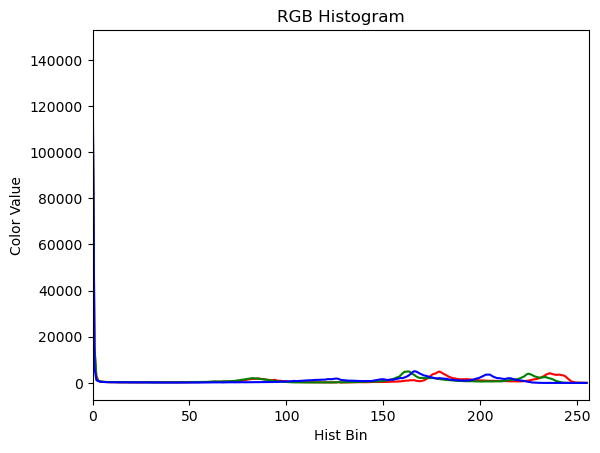

In [12]:
image = cv2.imread(image_bcrop_path)

color = ['r','g','b']
for idx, col in enumerate(color):
    hist_result = cv2.calcHist([image],[idx],None,[256],[0,256])
    plt.plot(hist_result, color=col)
plt.title('RGB Histogram')
plt.xlim([0,256])
plt.xlabel('Hist Bin')
plt.ylabel('Color Value')
plt.show()

## 이미지에서 가장 많은 비율을 차지하는 색깔

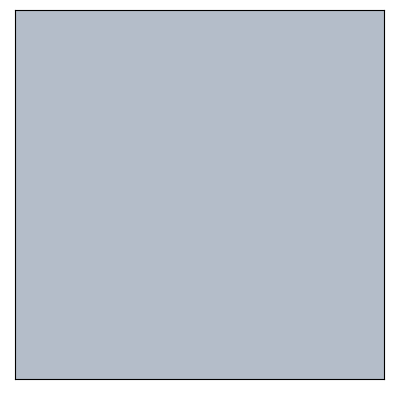

In [13]:
ct = ColorThief(image_bcrop_path)
dominant_color = ct.get_color(quality=1)

plt.imshow([[dominant_color]])
plt.xticks([]), plt.yticks([])
plt.show()

## 이미지의 색깔 팔레트 추출

In [14]:
palette01 = ct.get_palette(color_count=palette_num)
plt.imshow([[palette01[i] for i in range(palette_num-1)]])
plt.xticks([]), plt.yticks([])
plt.show()
print(palette01)

[(116, 78, 79), (192, 208, 223), (60, 97, 119), (113, 147, 170), (60, 49, 53), (26, 21, 23), (178, 186, 204), (185, 197, 210), (142, 129, 126), (123, 90, 95), (173, 181, 193), (152, 145, 144), (80, 58, 61), (137, 155, 174), (95, 75, 93), (220, 236, 243), (188, 182, 185), (56, 27, 29), (140, 92, 84), (123, 112, 120), (172, 168, 184), (148, 111, 112), (211, 236, 242), (69, 140, 173), (163, 156, 156), (41, 76, 108), (148, 157, 174), (92, 66, 68), (228, 241, 245), (180, 171, 166), (164, 142, 130), (212, 227, 238), (116, 100, 84), (88, 91, 104), (100, 70, 73), (68, 164, 180), (105, 113, 140), (145, 132, 156), (150, 198, 230), (172, 159, 147), (156, 159, 176), (36, 63, 80), (156, 148, 132), (132, 84, 83), (100, 95, 106), (132, 76, 92), (40, 44, 45), (77, 40, 36), (163, 172, 184), (140, 98, 99), (171, 172, 196), (204, 210, 208), (38, 34, 44), (125, 110, 106), (204, 228, 235), (204, 220, 233), (164, 164, 180), (180, 180, 164), (166, 165, 164), (156, 148, 164), (112, 164, 197), (196, 220, 229),

In [15]:
palette02 = extcolors.extract_from_path(image_bcrop_path, tolerance=12, limit=palette_num)
print(palette02)

([((166, 163, 182), 81650), ((205, 225, 236), 74554), ((0, 0, 0), 55203), ((125, 90, 96), 39142), ((181, 177, 166), 11378), ((94, 61, 59), 6942), ((149, 146, 141), 5214), ((87, 77, 78), 3058), ((66, 35, 40), 2629), ((50, 46, 52), 2369), ((126, 153, 177), 2244), ((142, 130, 150), 1225), ((99, 96, 113), 1152), ((26, 78, 107), 651), ((146, 120, 111), 648), ((8, 28, 38), 477), ((63, 136, 173), 456), ((172, 218, 248), 215), ((36, 62, 68), 160), ((53, 124, 135), 128), ((173, 190, 200), 127), ((96, 69, 86), 96), ((110, 112, 111), 73), ((121, 174, 213), 55), ((91, 156, 174), 33), ((39, 26, 23), 30), ((14, 46, 69), 27), ((58, 92, 102), 22), ((55, 52, 82), 20), ((0, 21, 50), 12), ((30, 20, 35), 9), ((98, 120, 149), 8), ((78, 87, 123), 5), ((60, 60, 50), 3), ((22, 106, 133), 1)], 395641)


# 퍼스널 컬러 진단

In [16]:
def is_warm(lab_b, a):
    '''
    파라미터 lab_b = [skin_b, hair_b, eye_b]
    a = 가중치 [skin, hair, eye]
    질의색상 lab_b값에서 warm의 lab_b, cool의 lab_b값 간의 거리를
    각각 계산하여 warm이 가까우면 1, 반대 경우 0 리턴
    '''
    # standard of skin, eyebrow, eye
    warm_b_std = [11.6518, 11.71445, 3.6484]
    cool_b_std = [4.64255, 4.86635, 0.18735]

    warm_dist = 0
    cool_dist = 0

    body_part = ['skin', 'eyebrow', 'eye']
    for i in range(len(lab_b)):
        warm_dist += abs(lab_b[i] - warm_b_std[0]) * a[0]
        #print(body_part[i],"의 warm 기준값과의 거리")
        #print(abs(lab_b[i] - warm_b_std[i]))
        cool_dist += abs(lab_b[i] - cool_b_std[0]) * a[0]
        #print(body_part[i],"의 cool 기준값과의 거리")
        #print(abs(lab_b[i] - cool_b_std[i]))
    
    if(warm_dist <= cool_dist):
        return 1 #warm
    else:
        return 0 #cool

def is_spr(hsv_s, a):
    '''
    파라미터 hsv_s = [skin_s, hair_s, eye_s]
    a = 가중치 [skin, hair, eye]
    질의색상 hsv_s값에서 spring의 hsv_s, fall의 hsv_s값 간의 거리를
    각각 계산하여 spring이 가까우면 1, 반대 경우 0 리턴
    '''
    #skin, hair, eye
    spr_s_std = [18.59296, 30.30303, 25.80645]
    fal_s_std = [27.13987, 39.75155, 37.5]

    spr_dist = 0
    fal_dist = 0

    body_part = ['skin', 'eyebrow', 'eye']
    for i in range(len(hsv_s)):
        spr_dist += abs(hsv_s[i] - spr_s_std[0]) * a[0]
        # print(body_part[i],"의 spring 기준값과의 거리")
        # print(abs(hsv_s[i] - spr_s_std[i]) * a[i])
        fal_dist += abs(hsv_s[i] - fal_s_std[0]) * a[0]
        # print(body_part[i],"의 fall 기준값과의 거리")
        # print(abs(hsv_s[i] - fal_s_std[i]) * a[i])

    if(spr_dist <= fal_dist):
        return 1 #spring
    else:
        return 0 #fall

def is_smr(hsv_s, a):
    '''
    파라미터 hsv_s = [skin_s, hair_s, eye_s]
    a = 가중치 [skin, hair, eye]
    질의색상 hsv_s값에서 summer의 hsv_s, winter의 hsv_s값 간의 거리를
    각각 계산하여 summer가 가까우면 1, 반대 경우 0 리턴
    '''
    #skin, eyebrow, eye
    smr_s_std = [12.5, 21.7195, 24.77064]
    wnt_s_std = [16.73913, 24.8276, 31.3726]
    a[1] = 0.5 # eyebrow 영향력 적기 때문에 가중치 줄임

    smr_dist = 0
    wnt_dist = 0

    body_part = ['skin', 'eyebrow', 'eye']
    for i in range(len(hsv_s)):
        smr_dist += abs(hsv_s[i] - smr_s_std[0]) * a[0]
        # print(body_part[i],"의 summer 기준값과의 거리")
        # print(abs(hsv_s[i] - smr_s_std[i]) * a[i])
        wnt_dist += abs(hsv_s[i] - wnt_s_std[0]) * a[0]
        # print(body_part[i],"의 winter 기준값과의 거리")
        # print(abs(hsv_s[i] - wnt_s_std[i]) * a[i])

    if(smr_dist <= wnt_dist):
        return 1 #summer
    else:
        return 0 #winter

In [17]:
# colors = palette01
# Lab_weight = [30, 20, 5]
# hsv_weight = [10, 1, 1]
# lab_b = list()
# hsv_s = list()

In [18]:
# for color in colors:
#     rgb = sRGBColor(color[0],color[1],color[2], is_upscaled=True)
#     # print(f'RGB 분석: {rgb}')
#     lab = convert_color(rgb, LabColor, through_rgb_type=sRGBColor)
#     # print(f'LAB 분석: {lab}')
#     hsv = convert_color(rgb, HSVColor, through_rgb_type=sRGBColor)
#     # print(hsv)
#     lab_b.append(lab.lab_b)
#     hsv_s.append(hsv.hsv_s)

In [19]:
tone = list()
palette_gap = 5
for col_interval in range(0,palette_num,palette_gap):
    colors = palette01[col_interval:col_interval+10]
    Lab_weight = [30, 20, 5]
    hsv_weight = [10, 1, 1]
    lab_b = list()
    hsv_s = list()
    
    for color in colors:
        rgb = sRGBColor(color[0],color[1],color[2], is_upscaled=True)
        # print(f'RGB 분석: {rgb}')
        lab = convert_color(rgb, LabColor, through_rgb_type=sRGBColor)
        # print(f'LAB 분석: {lab}')
        hsv = convert_color(rgb, HSVColor, through_rgb_type=sRGBColor)
        # print(hsv)
        lab_b.append(lab.lab_b)
        hsv_s.append(hsv.hsv_s)
    
    if(is_warm(lab_b, Lab_weight)):
        if(is_spr(hsv_s, hsv_weight)):
            # tone = '봄웜톤(spring)'
            tone.append('봄웜톤(spring)')
        else:
            # tone = '가을웜톤(fall)'
            tone.append('가을웜톤(fall)')
    else:
        if(is_smr(hsv_s, hsv_weight)):
            # tone = '여름쿨톤(summer)'
            tone.append('여름쿨톤(summer)')
        else:
            # tone = '겨울쿨톤(winter)'
            tone.append('겨울쿨톤(winter)')
    # Print Result
    # print(f'퍼스널 컬러는 {tone}입니다.')

In [20]:
print(tone)

['여름쿨톤(summer)', '여름쿨톤(summer)', '여름쿨톤(summer)', '여름쿨톤(summer)', '여름쿨톤(summer)', '여름쿨톤(summer)', '여름쿨톤(summer)', '여름쿨톤(summer)', '여름쿨톤(summer)', '여름쿨톤(summer)', '여름쿨톤(summer)', '여름쿨톤(summer)', '여름쿨톤(summer)', '여름쿨톤(summer)', '여름쿨톤(summer)', '여름쿨톤(summer)', '여름쿨톤(summer)', '여름쿨톤(summer)', '여름쿨톤(summer)', '여름쿨톤(summer)']
